# 2. Small-scale ChatGPT - generování textu pomocí neuronových sítí

## Úkoly
1. Seznámení s datasety - jména ČR (můž, žena, neutrál), různé státy
2. Vykreslit histogram délek jmen
3. Konstrukce tří-vrstvého perceptronu - vyzkoušení generování slov
4. Konstrukce rekureního modelu - potřeba k zahrnutí vzájemných závislostí prvků sekvence
    - vyzkoušet: různé aktivační funkce, learning rate, počet rekurentních bloků, počet skrytých neuronů
5. Přidání teploty - ovlivnění výstupu, jak moc si NN vymýšlí
6. Přidání prvního znaku - NN bude generovat sama i první znak jména
7. Cíl: Rozumně vypadající vygenerovaná jména.

Bonusy:
1. Jiný dataset - CZ jména, jiná národnost, pouze muž/žena
2. LSTM, GRU ?

In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

!pip install -r requirements.txt

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [3]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
device = 'cpu'  # Force CPU for this example

In [5]:
torch.device(device)

device(type='cpu')

## Příprava dat I

Databáze evropských jmen a příjmení: https://data.europa.eu/data/datasets/5bc35259634f41122d982759?locale=cs

* Složka: /datasets/Seznam křestních jmen a příjmení

Databáze českých jmen: https://mv.gov.cz/clanek/seznam-rodove-neutralnich-jmen.aspx

* Složka /datasets/SeznamJmenCR

In [6]:
import glob
import pandas as pd

In [7]:
dfs = pd.read_csv('datasets/SeznamJmenCR/OpenData_-_Seznam_jmen_k_2025-05-31.csv', encoding='utf-8')
jmena_typ = dfs.iloc[:, 0]
jmena_all = dfs.iloc[:, 1]
jmena_all.shape

(11331,)

In [ ]:
jmena_all = jmena_all[jmena_typ == 'ZENA']

array(['AALIYAH', 'AAMU', 'AARIFA', ..., 'ŽIVANA', 'ŽOFIA', 'ŽOFIE'],
      shape=(3950,), dtype=object)

In [9]:
jmena_all, idx = np.unique(jmena_all, return_index=True)
jmena_typ = jmena_typ[idx]
jmena_all.shape, jmena_typ.shape

((11172,), (11172,))

In [10]:
jmena_all[:11]  # every 150th name

array(['AADAR', 'AAGTE', 'AAI', 'AAIKE', 'AAJARAQ', 'AAJU', 'AAJUNNGUAQ',
       'AAKA', 'AAKKULUK', 'AAL', 'AALIYAH'], dtype=object)

Vyčištění speciálních znaků

In [11]:
import string

jmena_all2 = []

# Set vocab to all utf-8 printable characters
vocab = list('`1234567890-=[];\',./*-+.~!@#$%^&*()_+{}:"|<>?')

names_length = []

for jmeno in jmena_all:
    cleaned = ''.join([ch for ch in str(jmeno) if ch not in vocab])
    first_seq = cleaned.split()[0] if cleaned.split() else ''
    first_seq = first_seq.lower()
    first_seq = first_seq[0].upper() + first_seq[1:]
    jmena_all2.append(first_seq)
    names_length.append(len(first_seq))
    
jmena_all2 = np.array(jmena_all2)
jmena_typ = np.array(jmena_typ)
len(jmena_all2)

11172

([<matplotlib.axis.XTick at 0x1a0d0a25c90>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19')])

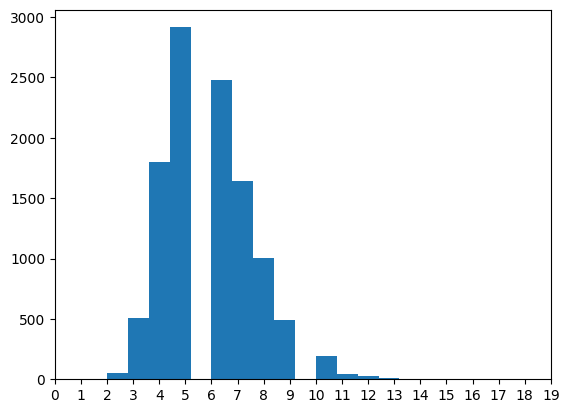

In [17]:
# DOPLNIT: histogram (krok 2)
plt.hist(names_length, bins=20)
plt.xticks(np.arange(20))

In [53]:
jmena_all2, idx = np.unique(jmena_all2, return_index=True)
jmena_typ2 = jmena_typ[idx]
jmena_all2.shape, jmena_typ2.shape

((11153,), (11153,))

In [54]:
positions = np.where(jmena_all2 == 'JAN **')[0]
print(positions)

[]


EOS = '\n', START = '$'

<img src="../images/names.png" alt="Rekurentní neuronová síť" width="800"/>

In [ ]:
# The unique characters in the file
vocab = np.array(sorted(set(''.join(jmena_all2))))

# insert special starting character
#vocab = np.append(vocab,'$')

print(f'{len(vocab)} unique characters')
print(vocab)

Příprava na zpracování

In [ ]:
all_letters = ''.join(vocab)
n_letters = len(all_letters) + 1 # Plus EOS marker
all_letters

In [ ]:
names_all = jmena_all2
names_all.shape, names_all[::180]

## Příprava dat II

Databáze jmen z různých států: https://docs.pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

In [ ]:
from io import open
import glob
import os
import unicodedata
import string
import numpy as np

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
names_all = []
names_length = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    names_all = np.concatenate([names_all, lines])
    for l in lines:
        names_length.append(len(l))

n_categories = len(all_categories)

print(f'Total names count: {len(names_all)}')

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

In [ ]:
# DOPLNIT: histogram (krok 2)

In [ ]:
all_letters

## Konstrukce neuronové sítě

Návod: https://docs.pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html

In [ ]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        # DOPLNIT: inicializace vrstev

    def forward(self, input, temperature = 1):
        
        # DOPLNIT: struktura RNN
        
        return output, self.hidden

    def initHidden(self):
        self.hidden = torch.zeros(1, self.hidden_size).to(device)
        

learning_rate = ?
n_hidden = ?  # počet skrytých neuronů

rnn = RNN(n_letters, n_hidden, n_letters).to(device)
print(rnn)

In [ ]:
from torchsummary import summary

rnn.initHidden()
summary(rnn, input_size=(1,n_letters), device=device)

## Formátování textu
* Převedení na *one-hot* reprezentaci

For each timestep (that is, for each letter in a training word) the
inputs of the network will be `(category, current letter, hidden state)`
and the outputs will be `(next letter, next hidden state)`. So for each
training set, we\'ll need the category, a set of input letters, and a
set of output/target letters.

Since we are predicting the next letter from the current letter for each
timestep, the letter pairs are groups of consecutive letters from the
line - e.g. for `"ABCD<EOS>"` we would create (\"A\", \"B\"), (\"B\",
\"C\"), (\"C\", \"D\"), (\"D\", \"EOS\").

![](https://i.imgur.com/JH58tXY.png)

The category tensor is a [one-hot
tensor](https://en.wikipedia.org/wiki/One-hot) of size
`<1 x n_categories>`. When training we feed it to the network at every
timestep - this is a design choice, it could have been included as part
of initial hidden state or some other strategy.


### Zpracování textu na tokeny

In [60]:
# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line, n_letters):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# ``LongTensor`` of second letter to end (EOS) for target
def targetTensor(line, n_letters):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [ ]:
all_letters

For convenience during training we\'ll make a `randomTrainingExample`
function that fetches a random (category, line) pair and turns them into
the required (category, input, target) tensors.


In [62]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample(samples_all, n_letters):
    sample = randomChoice(samples_all)
    input_line_tensor = inputTensor(sample, n_letters)
    target_line_tensor = targetTensor(sample, n_letters)
    return input_line_tensor, target_line_tensor

## Trénování neuronové sítě

In [ ]:
criterion = nn.NLLLoss().to(device)

def train(input_line_tensor, target_line_tensor):
    target_line_tensor = target_line_tensor.unsqueeze_(-1).to(device)
    rnn.initHidden()

    rnn.zero_grad()

    loss = torch.Tensor([0]).to(device) # you can also just simply use ``loss = 0``

    for i in range(input_line_tensor.size(0)):
        output, _ = rnn(input_line_tensor[i].to(device))
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

To keep track of how long training takes I am adding a
`timeSince(timestamp)` function which returns a human readable string:


In [64]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Training is business as usual - call train a bunch of times and wait a
few minutes, printing the current time and loss every `print_every`
examples, and keeping store of an average loss per `plot_every` examples
in `all_losses` for plotting later.


In [ ]:
rnn = RNN(n_letters, n_hidden, n_letters).to(device)

n_iters = ?
print_every = ?
plot_every = 500
all_losses = []
total_loss = 0 # Reset every ``plot_every`` ``iters``
total_loss2 = 0 # Reset every ``print_every`` ``iters``

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample(names_all, n_letters))
    total_loss += loss
    total_loss2 += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, total_loss2 / print_every))
        total_loss2 = 0

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

Plotting the Losses
===================

Plotting the historical loss from all\_losses shows the network
learning:


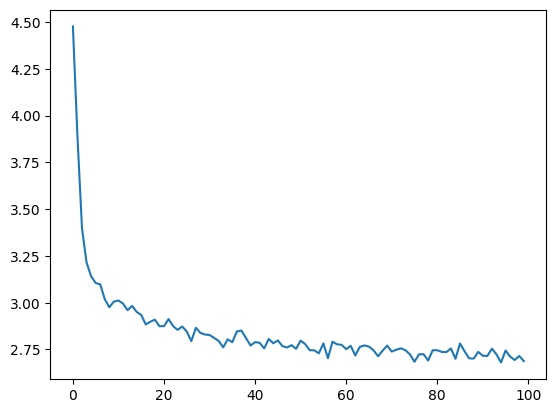

In [66]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses);

In [ ]:
import datetime

dt = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
print(dt)

import os
os.makedirs('results', exist_ok=True)

torch.save(rnn.state_dict(), f'results/model2_jmena_rnn_{dt}.pth')

In [ ]:
rnn = RNN(n_letters, n_hidden, n_letters).to(device)

rnn.load_state_dict(torch.load('results/model2_jmena_rnn_20250623032853.pth'))

## Vzorkování natrénováné RNN

To sample we give the network a letter and ask what the next one is,
feed that in as the next letter, and repeat until the EOS token.

-   Create tensors for input category, starting letter, and empty hidden
    state
-   Create a string `output_name` with the starting letter
-   Up to a maximum output length,
    -   Feed the current letter to the network
    -   Get the next letter from highest output, and next hidden state
    -   If the letter is EOS, stop here
    -   If a regular letter, add to `output_name` and continue
-   Return the final name



In [ ]:
max_length = 20

# Sample from a category and starting letter
def sample(start_letter='A', temperature=1):
    with torch.no_grad():  # no need to track history in sampling
        input = inputTensor(start_letter, n_letters)
        rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            #print(torch.exp(output.squeeze()))
            
            if temperature != 'max':  # sample from distribution
                output, _ = rnn(input[0].to(device), temperature=temperature)
                
                a = torch.arange(n_letters).to(device)
                p = torch.exp(output.squeeze())  # temperature
                index = p.multinomial(num_samples=1, replacement=True)
                topi = a[index]
            else:  # max
                output, _ = rnn(input[0].to(device), temperature=1)
                topv, topi = output.topk(1)
                topi = topi[0][0]
                
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter, n_letters)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(start_letters='ABC', temperature=1):
    for start_letter in start_letters:
        sample_name = sample(start_letter, temperature)
        txt = ' '*(22-len(sample_name))
        print(f'{sample_name}{txt}| je v datasetu: ', sample_name in names_all)

#samples('ADJLHOLAD', temperature = 'max')
samples('ADJLHOLAD', temperature = 0.3)

## Vizualizace

!pip install torchview

In [99]:
from torchviz import make_dot
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

y_pred = rnn(inputTensor('A', n_letters)[0].to(device))  # Get predictions for the first training sample

make_dot(y_pred, params=dict(list(rnn.named_parameters()))).render("rnn_torchviz", format="png")

'rnn_torchviz.png'

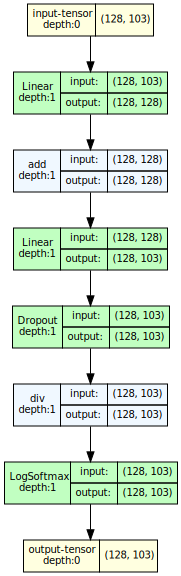

In [104]:
import torchvision
from torchview import draw_graph

rnn.initHidden()
model_graph = draw_graph(rnn, input_size=(n_hidden,n_letters), expand_nested=True, device=device)
model_graph.visual_graph

In [ ]:
rnn.hidden

In [ ]:
max_length = 20

# Sample from a category and starting letter
def sampleAnalysis(start_letter='A', temperature=1):
    list_prob = []
    list_hidden_states = []
    
    with torch.no_grad():  # no need to track history in sampling
        input = inputTensor(start_letter, n_letters)
        rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            #print(torch.exp(output.squeeze()))
            
            if temperature != 'max':  # sample from distribution
                output, _ = rnn(input[0].to(device), temperature=temperature)
                
                propabilities = torch.exp(output.squeeze())  # temperature
                index = propabilities.multinomial(num_samples=1, replacement=True)
                list_prob.append(propabilities)
                
                a = torch.arange(n_letters).to(device)
                topi = a[index]
            else:  # max
                output, _ = rnn(input[0].to(device), temperature=1)
                topv, topi = output.topk(1)
                topi = topi[0][0]
                
            list_hidden_states.append(rnn.hidden)
                                
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter, n_letters)

        return output_name, list_prob, list_hidden_states

# CHANGE START LETTER
start_letter = 'E'

output_name, list_prob, list_hidden_states = sampleAnalysis(start_letter, temperature = 0.8)
txt = ' '*(22-len(output_name))
print(f'{output_name}{txt}| je v datasetu: ', output_name in names_all)

Ealavke               | je v datasetu:  False


In [ ]:
len(all_letters), all_letters

(102,
 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyzÁÇÉÍÓÖÜáâäæçéëíïóôöøúûüýĆČčďěĽľŁłňŘřŞşŠšŤťůűźżŽžʼ$')

In [ ]:
first_cnt = 10
first_ind = [torch.topk(prob, first_cnt, dim=0).indices.numpy() for prob in list_prob]
first_prob = [prob[torch.topk(prob, first_cnt, dim=0).indices.numpy()] for prob in list_prob]
first_letters = [[all_letters[idx] if idx < len(all_letters) else 'EOS' for idx in torch.topk(prob, first_cnt, dim=0).indices.numpy()] for prob in list_prob]

zarr = np.zeros(first_cnt)
zarr[0] = 1
first_prob.insert(0, zarr)

charr = ['']*(first_cnt-1)
charr.insert(0,start_letter)
first_letters.insert(0, charr)

#first_ind, first_prob, first_letters

In [ ]:
list(output_name)

['E', 'a', 'l', 'a', 'v', 'k', 'e']

Hodnoty aktivace pro konkrétní neuron ve skryté vrstvě

In [ ]:
neur_idx = 1

list_hidden_states = np.array(list_hidden_states).squeeze()
hidd_states = list_hidden_states[:,neur_idx]
hidd_states = np.insert(hidd_states, 0, 0)
hidd_states

array([ 0.        , -0.07578509, -0.36010897, -0.91851234, -1.336549  ,
       -1.524146  , -1.6372837 , -1.7838877 ], dtype=float32)

In [ ]:
np.insert(first_prob, 0, 0, axis=0)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.20061983, 0.14512566, 0.08226797, 0.07782461, 0.07158079,
        0.06108891, 0.05420543, 0.05408461, 0.02366396, 0.02159487],
       [0.26792637, 0.24500218, 0.07636154, 0.05460576, 0.04006299,
        0.03544253, 0.03368717, 0.0286148 , 0.02182723, 0.01881991],
       [0.23897254, 0.20944875, 0.20298781, 0.0515274 , 0.03509137,
        0.03126996, 0.0261696 , 0.02332604, 0.02142181, 0.01904682],
       [0.59442061, 0.07859479, 0.04832272, 0.044892  , 0.02730436,
        0.01680035, 0.01647219, 0.01464469, 0.01440912, 0.0118991 ],
       [0.31559131, 0.27130988, 0.16887985, 0.08487671, 0.01854577,
        0.01736904, 0.01531465, 0.01238602, 0.00870397, 0.00734951],
       [0.37546197, 0.37028736, 0.1404809

[[0.5        0.5        0.5337876  0.4499274  0.47020406 0.43090636
  0.4123119  0.4638193  0.5633949 ]
 [0.5        0.5        0.5908886  0.6284456  0.6582888  0.5871348
  0.5293862  0.4935395  0.44581416]
 [0.5        0.5        0.42193493 0.34559494 0.3420299  0.3136924
  0.26444465 0.25478578 0.284875  ]
 [0.5        0.5        0.39777896 0.35573307 0.3272938  0.33072612
  0.31852686 0.3003137  0.2807517 ]
 [0.5        0.5        0.40311497 0.37730387 0.3650653  0.36179906
  0.37671608 0.39607164 0.41503328]
 [0.5        0.5        0.4354283  0.40262616 0.45514223 0.4289041
  0.43952554 0.48405614 0.534953  ]
 [0.5        0.5        0.5419657  0.4866691  0.45652497 0.43198037
  0.40281287 0.35420954 0.28416175]
 [0.5        0.5        0.57663214 0.6413209  0.7619112  0.7895
  0.7979874  0.81531996 0.8293918 ]
 [0.5        0.5        0.53403956 0.5513421  0.61676633 0.61255175
  0.6162941  0.6155658  0.60621876]
 [0.5        0.5        0.43858436 0.47428122 0.4865652  0.49909398
  0

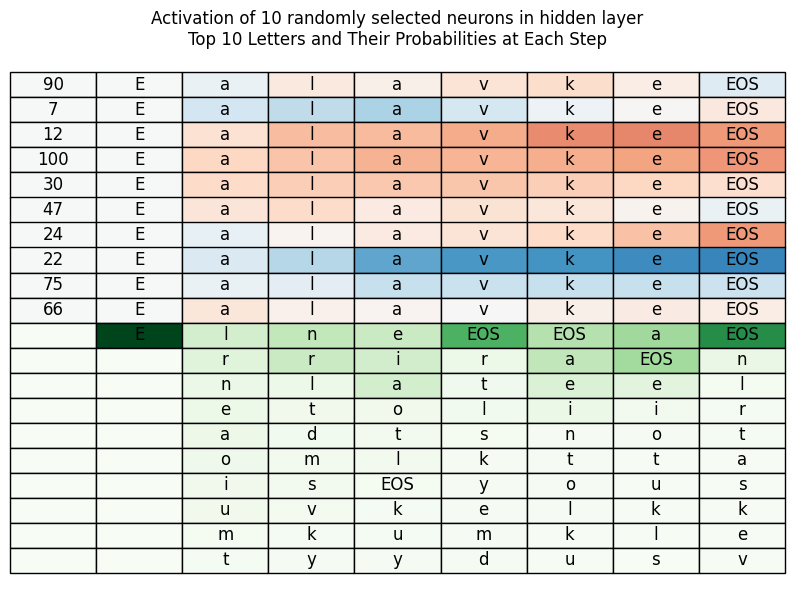

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

hidden_neur_cnt = 10

# Select hidden_neur_cnt random unique indices from 0 to list_hidden_states.shape[1] - 1
#np.random.seed(42)
hidden_indices = np.random.choice(list_hidden_states.shape[1], hidden_neur_cnt, replace=False)

list_hidden_states = np.array(list_hidden_states.squeeze())
hidd_states = list_hidden_states[:,hidden_indices]
hidd_states = np.insert(hidd_states, 0, 0, axis=0)
hidd_states = np.insert(hidd_states, 0, 0, axis=0).T
    
# Convert first_prob tensors to numpy arrays for easier handling
#probs = [p.detach().cpu().numpy() for p in first_prob]
probs = np.insert(first_prob, 0, 0, axis=0)
#probs = first_prob
#print(len(probs))

first_lett = np.insert(first_letters, 0, '', axis=0)

# Create a table of letters and their probabilities
table_data = []
for i in range(first_cnt):
    row = []
    for step in range(len(first_lett)):
        if i < len(first_lett[step]):
            row.append(first_lett[step][i])
        else:
            row.append('')
    table_data.append(row)

for ni in range(hidden_neur_cnt):
    table_data.insert(0, [hidden_indices[ni]] + list(output_name) + ['EOS'])

# Create a table of probabilities for coloring
prob_data = []

# Add the output_name as the first row in the table
for i in range(first_cnt):
    row = []
    for step in range(len(probs)):
        if i < len(probs[step]):
            row.append(probs[step][i])
        else:
            row.append(0)
    prob_data.append(row)
    
    

# Plot the table
fig, ax = plt.subplots(figsize=(10, 4+hidden_neur_cnt//3))

table = ax.table(cellText=table_data,
                cellLoc='center',
                loc='center')

# Normalize hidd_states for coloring the first row
hidd_states_norm = (torch.sigmoid(torch.tensor(hidd_states)).numpy())    

print(hidd_states_norm)

# Create a colormap for the first row (e.g., Blues)
first_row_colors = plt.cm.RdBu(hidd_states_norm)

# Prepare the rest of the cell colors using prob_data (skip the first row)
prob_colors = plt.cm.Greens(np.array(prob_data))

# Combine first row and the rest
cell_colours = np.vstack([first_row_colors, prob_colors])

# Set the cell colors
for i in range(len(cell_colours)):
    for j in range(len(cell_colours[i])):
        table[(i, j)].set_facecolor(cell_colours[i, j])
                        
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)  # width, height scaling; 1.5*10=15px height per row if default is 10


ax.axis('off')
ax.set_title('Activation of 10 randomly selected neurons in hidden layer\nTop 10 Letters and Their Probabilities at Each Step')
    
    
plt.show()

## Zdroje

https://karpathy.github.io/2015/05/21/rnn-effectiveness/

https://docs.pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

https://www.tensorflow.org/text/tutorials/text_generation